# Step-by-Step Tutorial on Training an ODE Model with BPTT
Pavel Nakaznenko, 2024

Telegram-channel:[То шо нейросети](https://t.me/toshoseti)

## Introduction
In this tutorial, I will guide you through the process of training an ordinary differential equation (ODE) model using a neural network and Backpropagation Through Time (BPTT). I will break down the code into sections, explaining the theory and details at each step.

## Theory
Ordinary Differential Equations (ODEs) are equations involving derivatives of a function. Neural ODEs are a class of models where a neural network defines the derivatives, allowing us to model continuous-time processes.

We use the Euler method for numerical integration in this tutorial for simplicity. However, it's worth noting that more sophisticated methods like Runge-Kutta or Adaptive solvers (e.g., Dormand-Prince) can provide better accuracy and efficiency.

## Why BPTT instead of Adjoint Method?
Backpropagation Through Time (BPTT) is a technique used to train models with temporal dependencies. While the adjoint method is often used in Neural ODEs for its memory efficiency, BPTT is chosen here for its straightforward implementation and to illustrate the concept in a more accessible manner.

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## Define the Neural ODE Function
Here, we define a neural network model to represent the right-hand side of our ODE.

In [2]:
class ODEFunc(nn.Module):
    """
    Neural network modeling the right-hand side of an ODE.
    """
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )

    def forward(self, t, y):
        return self.net(y)

## Euler Integration Step
We use the Euler method for numerical integration. While Euler is simple, it is not the most efficient or accurate. Alternatives include the Runge-Kutta method or adaptive solvers.

In [3]:
def euler_step(func, y, t, dt):
    """
    Perform a single Euler integration step.
    """
    return y + dt * func(t, y)

## Generate Spiral Data
We generate synthetic spiral data with some noise for training and validation.

In [4]:
def generate_spiral_data(num_step=100, noise_level=0.1):
    """
    Generate noisy spiral data.
    """
    t = torch.linspace(0., 25., num_step)
    x = t * torch.sin(t) + noise_level * torch.randn(t.size())
    y = t * torch.cos(t) + noise_level * torch.randn(t.size())
    return torch.stack((x, y), dim=1), t

## Training the Model
The training process involves backpropagation through time (BPTT) to handle temporal dependencies in the data.

In [5]:
def train_model(model, optimizer, criterion, train_data, train_times, ode_steps, dt, bptt_steps, epochs, device):
    """
    Train the ODE model.
    """
    for epoch in range(epochs):
        total_train_loss = 0
        train_y_preds = torch.tensor([]).float().to(device)

        model.train()
        i = 0
        while i < len(train_data['input']):
            optimizer.zero_grad() 
            # We accumulate loss through the series of bptt_steps step (backpropagation through time)
            current_loss = 0
            bptt_end = min(i + bptt_steps, len(train_data['input']))

            for b in range(i, bptt_end):
                current_time = train_data['times'][b]
                current_input = train_data['input'][b].detach().requires_grad_(True).to(device)

                # Integrate ODE for ode_steps iterations
                for _ in range(ode_steps):
                    current_input = euler_step(model, current_input, current_time, dt)
                    current_time += dt  # Increment time step

                train_y_preds = torch.cat([train_y_preds, current_input.unsqueeze(0).detach()])
                loss = criterion(current_input, train_data['target'][b].to(device))
                current_loss += loss

            current_loss.backward()  # Backpropagate the loss through time
            optimizer.step()
            total_train_loss += current_loss.item()
            i += bptt_steps

        # Validate the model at regular intervals
        if (epoch % 50 == 0) or (epoch == epochs - 1):
            # Note: we supply the last sample from train data as the initial value
            val_loss, val_y_preds = validate_model(model, criterion, train_data['input'][-1], val_data, ode_steps, dt, device)
            plot_results(data, train_y_preds, val_y_preds)
            print(f'Epoch {epoch}, Train Loss: {total_train_loss / len(train_data["input"])}, Validation Loss: {val_loss / len(val_data["input"])}')

## Validate the Model
We validate the model to check its performance on unseen data.

In [6]:
def validate_model(model, criterion, initial_input, val_data, ode_steps, dt, device):
    """
    Validate the ODE model.
    """
    total_val_loss = 0
    val_y_preds = torch.tensor([]).float().to(device)

    model.eval()
    with torch.no_grad():
        current_input = initial_input.detach().to(device)

        for i in range(len(val_data['input'])):
            current_time = val_data['times'][i]

            # Integrate ODE over ode_steps iterations
            for _ in range(ode_steps):
                current_input = euler_step(model, current_input, current_time, dt)
                current_time += dt

            val_y_preds = torch.cat([val_y_preds, current_input.unsqueeze(0)])
            loss = criterion(current_input, val_data['target'][i].to(device))
            total_val_loss += loss.item()

    return total_val_loss, val_y_preds

## Plot Results
Finally, we visualize the original, training, and validation data.

In [7]:
def plot_results(data, train_y_preds, val_y_preds):
    """
    Plot the original, training, and validation data.
    """
    plt.figure(figsize=(8, 8))
    plt.plot(data[:, 0], data[:, 1], label='Original Spiral')
    train_y_preds_np = train_y_preds.detach().cpu().numpy()
    val_y_preds_np = val_y_preds.detach().cpu().numpy()
    plt.plot(train_y_preds_np[:, 0], train_y_preds_np[:, 1], 'r--', label='Train Predicted Spiral')
    plt.plot(val_y_preds_np[:, 0], val_y_preds_np[:, 1], 'b--', label='Validation Predicted Spiral', markersize=12, marker='o')
    plt.legend()
    plt.show()

## Hyperparameters and Data Generation
We define the hyperparameters and generate the data.

In [8]:
# Hyperparameters and data generation
epochs = 300
ode_steps = 10
dt = 1 / ode_steps  # Amount of ODE integration substeps
bptt_steps = 3  # Backpropagation through time steps
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu") # On this small scale example CPU calculations work faster

data, times = generate_spiral_data()
input_data = data[:-1] # The input values are all data values except the last one, 
target_data = data[1:] # so we could shift the target values by one

# Train/validation split
split_index = int(len(input_data) * 0.8)
train_data = {
    'input': input_data[:split_index].to(device),
    'target': target_data[:split_index].to(device),
    'times': times[:split_index].to(device)
}
val_data = {
    'input': input_data[split_index:].to(device),
    'target': target_data[split_index:].to(device),
    'times': times[split_index:].to(device)
}

# Model, optimizer, and loss
model = ODEFunc().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss() # Note: MAE loss yields faster convergence for the nature of our data

## Training

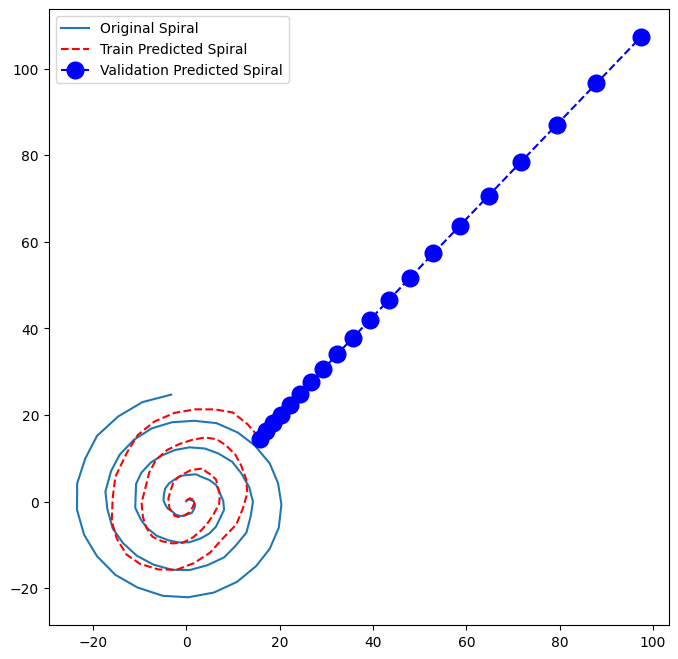

Epoch 0, Train Loss: 1.3167048356955564, Validation Loss: 49.99057483673096


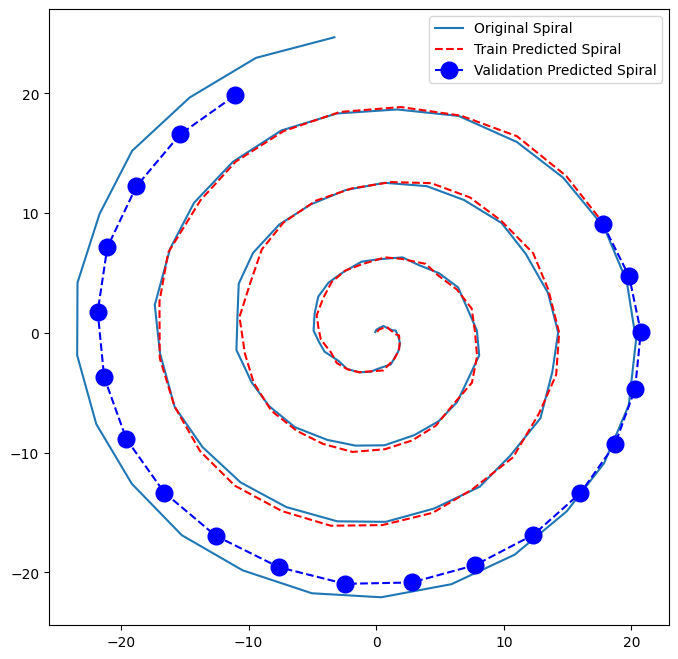

Epoch 50, Train Loss: 0.21713293994529337, Validation Loss: 4.862111842632293


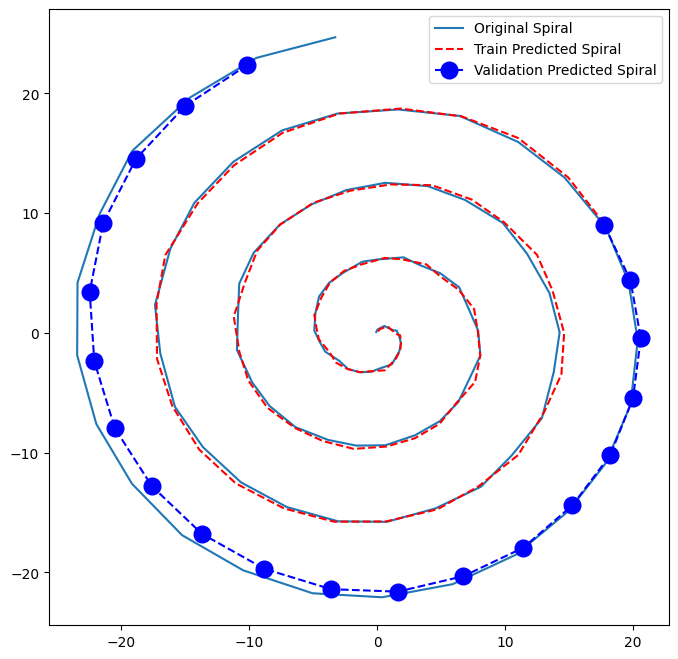

Epoch 100, Train Loss: 0.16520918735974952, Validation Loss: 4.091429662704468


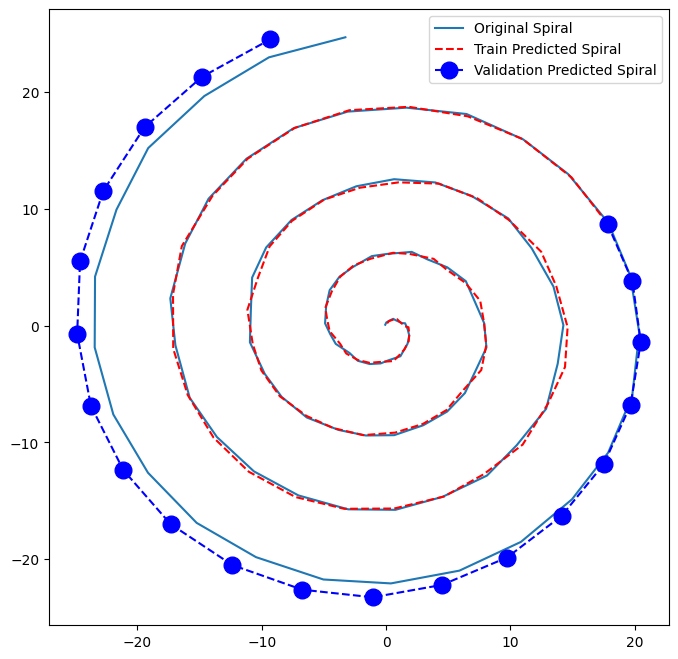

Epoch 150, Train Loss: 0.16441186960739426, Validation Loss: 3.0026286125183104


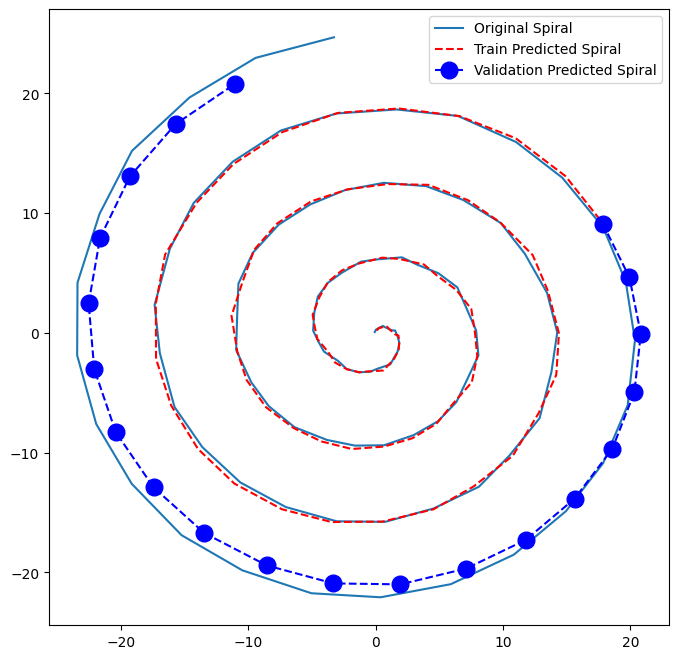

Epoch 200, Train Loss: 0.15938877833040455, Validation Loss: 4.5086739420890805


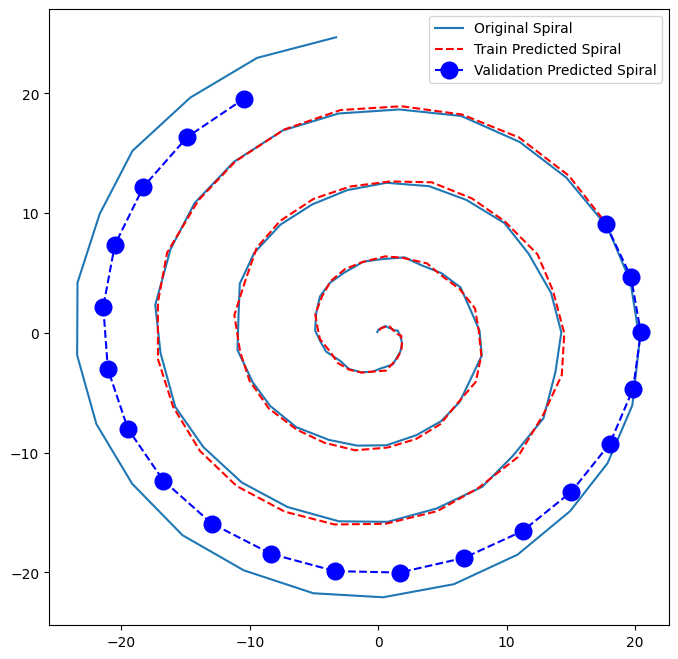

Epoch 250, Train Loss: 0.17994431830659696, Validation Loss: 4.52883073091507


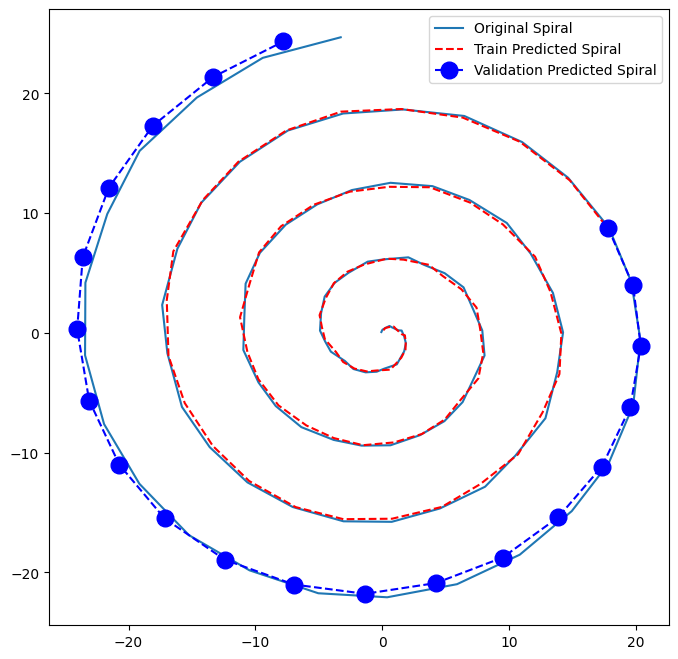

Epoch 299, Train Loss: 0.15427522380140762, Validation Loss: 2.6288226187229156


In [9]:
train_model(model, optimizer, criterion, train_data, train_data['times'], ode_steps, dt, bptt_steps, epochs, device)

## Conclusion
In this tutorial, we trained an ODE model using a neural network and BPTT. We chose the Euler method for simplicity, but more advanced methods can be used for better performance.